In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from utility import clean_data, plot_images
import math

In [127]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
from keras.models import load_model

In [128]:
filter_num = 64 # 每个卷积层取前64个filter（卷积核）
classes = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [129]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap='Blues'):
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix, without Normalization'
    print(title)
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    # plot heat-map
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True',
           xlabel='Predict')
    # Rotate the tick labels and set their alignment.
    ## `ha` is just shorthand for horizontalalignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [130]:
# prepare data
train_data = clean_data('data/train.csv')
train = train_data.feature.reshape((-1, 48, 48, 1))/255
train_x = train[:-2000]
train_label = train_data.label[:-2000]
train_onehot = train_data.onehot[:-2000]
test_x = train[-2000:]
test_label = train_data.label[-2000:]
test_onehot = train_data.onehot[-2000:]

In [131]:
cnn = load_model('model/cnn.h5')
dnn = load_model('model/dnn.h5')

In [132]:
# cnn prediction class
cnn_predict = cnn.predict(test_x)
cnn_cls = np.argmax(cnn_predict, axis=1)

In [133]:
# dnn prediction class to class number
dnn_predict = dnn.predict(test_x)
dnn_cls = np.argmax(dnn_predict, axis=1)

Confusion Matrix, without Normalization
[[125   6  26  26  31  12  80]
 [  6   5   2   4   3   2   2]
 [ 26   0  89  16  55  28  45]
 [  6   0   8 395  20  14  68]
 [ 22   0  17  29 160  10  89]
 [  6   0  19   8   7 179  18]
 [ 13   0  13  23  51   6 230]]


<AxesSubplot:title={'center':'Confusion Matrix, without Normalization'}, xlabel='Predict', ylabel='True'>

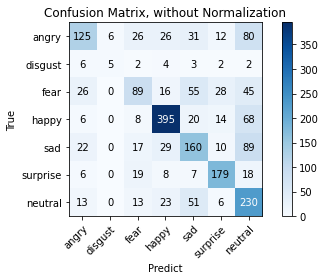

In [134]:
# plot confusion matrix
plot_confusion_matrix(test_label, cnn_cls, classes)

Confusion Matrix, without Normalization
[[ 15   0  76  83  69  18  45]
 [  1   0  10   6   3   4   0]
 [  5   0  86  50  62  24  32]
 [  0   0  67 334  62  11  37]
 [  5   0  64  81 113  12  52]
 [  1   0  57  36  19 104  20]
 [  3   0  62  86  59  18 108]]


<AxesSubplot:title={'center':'Confusion Matrix, without Normalization'}, xlabel='Predict', ylabel='True'>

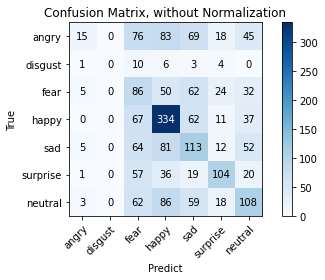

In [135]:
plot_confusion_matrix(test_label, dnn_cls, classes)

In [136]:
# show false prediction
true_cls = pd.Series(test_label, name='true_cls')[test_label!=cnn_cls]
wrong_pred_cls = pd.Series(cnn_cls, name='wrong_pred_cls')[test_label!=cnn_cls]

In [137]:
wrong = pd.concat([true_cls, wrong_pred_cls], axis = 1)

In [138]:
## pick true-sad pred-neutral
sad_neu_index = wrong[wrong['true_cls']==4][wrong['wrong_pred_cls']==6].index.tolist()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [139]:
sample_index = sad_neu_index[0:9]

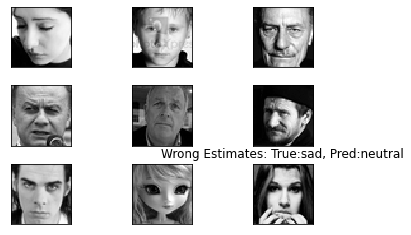

In [140]:
plot_images(test_x[sample_index], test_label[sample_index], cnn_cls[sample_index])


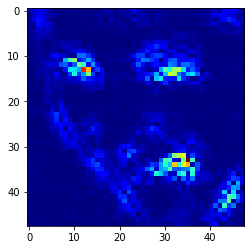

In [141]:
# Replace softmax with linear-avoid decay to probability
cnn.layers[-1].activation = activations.linear
cnn = utils.apply_modifications(cnn)

grads = visualize_saliency(cnn, -1, filter_indices=test_label[0], seed_input=test_x[0], backprop_modifier='guided')

plt.imshow(grads, cmap='jet')

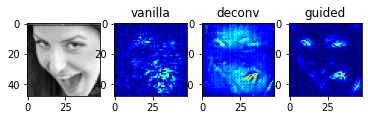

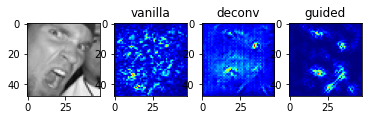

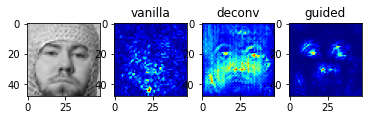

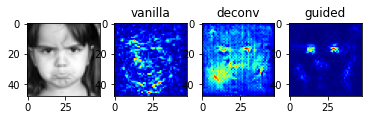

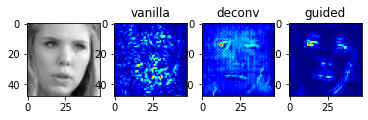

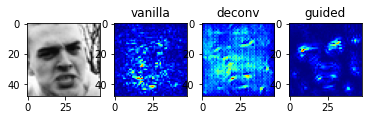

In [142]:
for idx in range(6):
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(test_x[idx].reshape((48,48)), cmap='gray')
    
    for i, modifier in enumerate([None, 'relu', 'guided']):
        grads = visualize_saliency(cnn, -1, filter_indices=test_label[idx], 
                                   seed_input=test_x[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        elif modifier is 'relu':
            modifier = 'deconv'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

### 分析网络每层结构与参数量

In [143]:
cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 48, 48, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 24, 24, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0   

In [144]:
layer_input = cnn.layers[0]
layer_conv1 = cnn.layers[1]
layer_conv2 = cnn.layers[5]
layer_conv3 = cnn.layers[9]
conv_layers = [layer_conv1, layer_conv2, layer_conv3]

In [145]:
layer_conv1.get_weights()[0].shape

(5, 5, 1, 64)

In [146]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(8, 8)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 第1-3层的weight
第一部分将要视觉化每一个卷积层的weight以及图片在输入每一个卷积层后的输出,即经过filter后的值. 由于filter的数目过多, 每一个卷积层均取前64个filter, 每个filter都只取第一个channel

for conv_layer in conv_layers:
    plot_conv_weights(conv_layer.get_weights()[0]) 

In [147]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(8, 8)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='Blues')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [148]:
from keras import backend as K

In [149]:
image = test_x[0]

### 4.查看某张图片的某层激活最大化的weight与输出
#### 原始图像

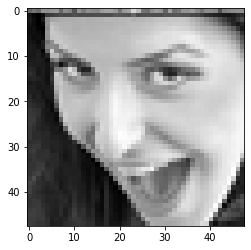

In [150]:
plt.imshow(image.reshape(48,48), cmap='gray')

In [151]:
output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])
output_conv2 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv2.output])
output_conv3 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv3.output])

In [152]:
image=image[np.newaxis, :, :]
layer_output1 = output_conv1(image)[0]
layer_output2 = output_conv2(image)[0]
layer_output3 = output_conv3(image)[0]

### 第1、5、9层的输出

plot_conv_output(values=layer_output1)

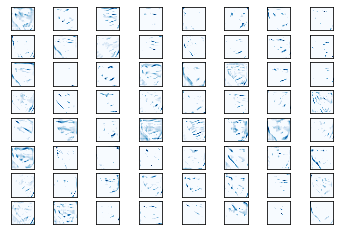

In [153]:
plot_conv_output(values=layer_output2)

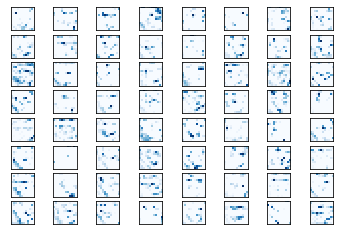

In [154]:
plot_conv_output(values=layer_output3)

In [155]:
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_conv1.output
filter_index = 0
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, layer_input.input)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([layer_input.input], [loss, grads])

In [156]:
# we start from a gray image with some noise
input_img_data = np.random.random((1, 48, 48, 1)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(500):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * 0.1

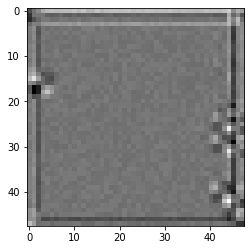

In [157]:
plt.imshow(input_img_data.reshape(48,48), cmap='gray')

In [158]:
# maximization activation
def _filter(layer_conv):
    result = []
    # channel_num*24(pic_height)*24(pic_width)*filter_num
    layer_output = layer_conv.output
    for filter_index in range(filter_num):
        # maximize output value = maximize loss
        loss = K.mean(layer_output[:, :, :, filter_index])
        # compute the gradient of the input picture's only channel with respect to loss
        grads = K.gradients(loss, layer_input.input)[0]
        # normalize: root mean square
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads of the given input picture
        iterate = K.function([layer_input.input], [loss, grads])
        input_img_data = np.random.random((1, 48, 48, 1)) * 20 + 128.
        # run gradient ascent for 20 steps
        for i in range(500):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * 0.1
        result.append(input_img_data.reshape(48,48))
        
    return result

In [159]:
plt.imshow(input_img_data.reshape(48,48), cmap='gray')

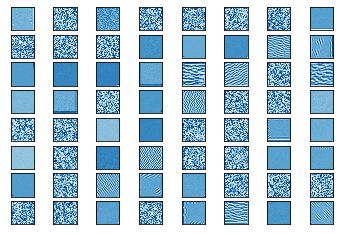

In [160]:
def _filter(layer_conv):
    result = []
    layer_output = layer_conv.output
    for filter_index in range(64):
        loss = K.mean(layer_output[:, :, :, filter_index])
        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, layer_input.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([layer_input.input], [loss, grads])
        input_img_data = np.random.random((1, 48, 48, 1)) * 20 + 128.
        # run gradient ascent for 20 steps
        for i in range(500):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * 0.1
        result.append(input_img_data.reshape(48,48))
        
    return result

ResourceExhaustedError: OOM when allocating tensor with shape[1,576,1600] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradients_588/layer_conv2_14/convolution_grad/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


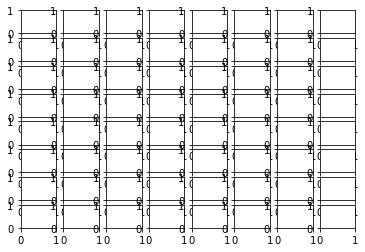

In [161]:
def plot_filter(layer_conv):
     # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(8, 8)
    img = _filter(layer_conv)
    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):

        ax.imshow(img[i], interpolation='nearest', cmap='Blues')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
plot_filter(layer_conv1)

In [ ]:
plot_filter(layer_conv2)

In [ ]:
plot_filter(layer_conv3)